## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [2]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')

In [3]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

with open('../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)
z_max['HST'] = [10, 10]

def set_cons(cons):
    global df
    
    zmax_cuts = dict()
    z_zcuts = dict()
    x1_zcuts = dict()
    x1_err_zcuts = dict()
    
    names = ['SNF' for i in range(len(surv['SNF']['host.zcmb']))]
    stretchs = list(surv['SNF']['salt2.X1'])
    stretchs_err = list(surv['SNF']['salt2.X1.err'])
    redshifts = list(surv['SNF']['host.zcmb'])
    infor = list(surv['SNF']['p(prompt)'])
    py = list(surv['SNF']['p(prompt)'])
    lssfr = list(surv['SNF']['lssfr'])
    lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
    lssfr_err_u = list(surv['SNF']['lssfr.err_up'])
    
    if cons:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    else:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
    for survey in surveys[1:]:
        names += [survey for i in range(len(z_zcuts[survey]))]
        stretchs += list(x1_zcuts[survey])
        stretchs_err += list(x1_err_zcuts[survey])
        redshifts += list(z_zcuts[survey])
        infor += list(stretchevol.Evol2G2M2S().delta(z_zcuts[survey]))
        py += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_d += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_u += list([0 for i in range(len(z_zcuts[survey]))])
        
    df = pd.DataFrame({'survey': names,
                       'stretchs': stretchs,
                       'stretchs_err': stretchs_err,
                       'redshifts': redshifts,
                       'infor': infor,
                       'py': py,
                       'lssfr': lssfr,
                       'lssfr_err_d': lssfr_err_d,
                       'lssfr_err_u': lssfr_err_u})

    z_mean = np.mean(df.redshifts)
    z_std = np.std(df.redshifts)
    x1_mean = np.mean(df.stretchs)
    x1_std = np.std(df.stretchs)
    
    return(df)
            
int_set_cons = ipw.interactive(set_cons, cons=cons)
display(int_set_cons)

names = ['SNF' for i in range(len(surv['SNF']['host.zcmb'].values))]
stretchs = list(surv['SNF']['salt2.X1'].values)
stretchs_err = list(surv['SNF']['salt2.X1.err'].values)
redshifts = list(surv['SNF']['host.zcmb'].values)
infor = list(surv['SNF']['p(prompt)'])
py = list(surv['SNF']['p(prompt)'])
lssfr = list(surv['SNF']['lssfr'])
lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
lssfr_err_u = list(surv['SNF']['lssfr.err_up'])

for survey in surveys[1:]:
    names += [survey for i in range(len(surv[survey].zCMB.values))]
    stretchs += list(surv[survey].x1.values)
    stretchs_err += list(surv[survey].x1ERR.values)
    redshifts += list(surv[survey].zCMB.values)
    infor += list(stretchevol.Evol2G2M2S().delta(surv[survey].zCMB.values))
    py += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_d += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_u += list([0 for i in range(len(surv[survey].zCMB.values))])

df_full = pd.DataFrame({'survey': names,
                        'stretchs': stretchs,
                        'stretchs_err': stretchs_err,
                        'redshifts': redshifts,
                        'infor': infor,
                        'py': py,
                        'lssfr': lssfr,
                        'lssfr_err_d': lssfr_err_d,
                        'lssfr_err_u': lssfr_err_u})

interactive(children=(Checkbox(value=False, description='Conservative'), Output()), _dom_classes=('widget-inte…

## Minimisation des modèles à mettre dans le _pandas_

In [4]:
gen = stretchevol.generic()
gen.set_model('Evol1G1M2S')

gen.set_data(df[df['survey'] == 'PS1'])
assymPS1 = gen.fit()

gen.set_data(df[df['survey'] == 'SDSS'])
assymSDSS = gen.fit()

gen.set_data(df[df['survey'] == 'SNLS'])
assymSNLS = gen.fit()

gen.set_data(df[df['survey'] == 'SNF'])
assymSNF = gen.fit()

gen.set_data(df)
assymTOT = gen.fit()

## Modèle _base_ pour comparaison

In [5]:
gen.set_model('Evol3G2M2SSNF')
gen.set_data(df[df['survey'] == 'SNF'])
base = gen.fit()

### Définition likelihood generic

In [6]:
def assym_law_gen(x, param):
    return(assymPS1.likelihood_tot(x, np.zeros(len(x)), param[0], param[1], param[2]))

# PS1

## Définition de _cov_ pour sélection aléatoire des paramètres

In [7]:
cov_PS1 = im.Minuit.matrix(assymPS1.m_tot)
mean_PS1 = [assymPS1.m_tot.values[i] for i in range(3)]
param_hesse_mat_PS1 = scipy.stats.multivariate_normal.rvs(mean=mean_PS1, cov=cov_PS1, size=500)

### List of all the models

In [10]:
xlin = np.linspace(-3, 3, 3000)
models_hesse_PS1 = [assym_law_gen(xlin, param_hesse) for param_hesse in param_hesse_mat_PS1]
models_hesse_PS1 = np.asarray(models_hesse_PS1)

### Take _std_

In [12]:
models_std_PS1 = np.std(models_hesse_PS1, axis=0)

## Tracé

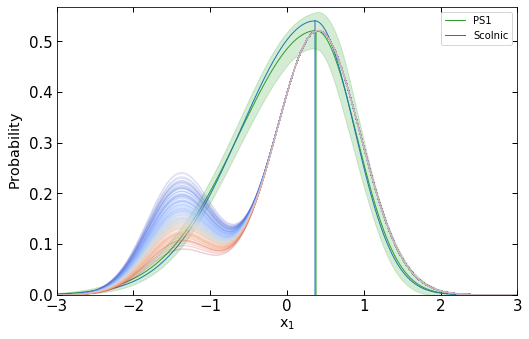

In [13]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

x_linspace = np.linspace(-3, 3, 3000)
flag_up = x_linspace >= assymPS1.param['mu']

color_p = "C2"

pdf_PS1 = assymPS1.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  assymPS1.param['mu'],
                                  assymPS1.param['sigma_m'],
                                  assymPS1.param['sigma_p'])

ax.plot(x_linspace,
        pdf_PS1,
        color=color_p,
        lw=1, label='PS1')

ax.fill_between(x_linspace,
                pdf_PS1 + models_std_PS1,
                pdf_PS1 - models_std_PS1,
                color=color_p,
                lw=1, alpha=.2)

ax.vline(assymPS1.param['mu'], ymin=0, ymax=np.max(pdf_PS1),
         color=color_p, alpha=.5, linewidth=2.0)

mu_s = 0.365
sigma_m_s = 0.963
sigma_p_s = 0.514
flag_up_s = x_linspace >= mu_s

color_s = "C0"

pdf_SCO = assymPS1.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  mu_s,
                                  sigma_m_s,
                                  sigma_p_s)

ax.plot(x_linspace,
        pdf_SCO,
        color=color_s, label='Scolnic',
        lw=1)

ax.vline(mu_s, 0, np.max(pdf_SCO),
         color=color_s, alpha=.5, linewidth=2.0)

dgmap = plt.cm.get_cmap('coolwarm')
nb_base = len(surv['PS1'].zCMB)
i = 0

z_m, z_p = np.percentile(surv['PS1'].zCMB, [0,100])

for z in surv['PS1'].zCMB: #np.linspace(0.05, 1, nb_base)[:-1]:
    pdf = base.likelihood_tot(base.delta(z),
                              x_linspace, np.zeros(len(x_linspace)),
                              base.param['aa'],
                              base.param['mu_1'], base.param['sigma_1'],
                              base.param['mu_2'], base.param['sigma_2'])

    ax.plot(x_linspace,
            np.max(pdf_PS1)/np.max(pdf)*pdf,
            color=dgmap((z-z_m)/(z_p-z_m)), alpha=.15,
            lw=1)
    i += 1
 
ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)
 
ax.set_xlim([-3, 3])
ax.set_ylim([0, np.max(pdf_PS1+models_std_PS1)+0.01])
                                                                      
ax.set_ylabel(r'$\mathrm{Probability}$', fontsize='x-large')
ax.set_xlabel(r'$\mathrm{x}_1$', fontsize='x-large')

ax.legend(ncol=1, loc='upper right')

fig.savefig('../../../Images/bbc_comp_PS1.pdf', bbox_inches='tight')

In [27]:
assymPS1.loglikelihood(0.384, 0.987, 0.505) + assymSDSS.loglikelihood(1.142, 1.652, 0.104) + assymSNLS.loglikelihood(0.974, 1.236, 0.283)

1109.9570088863675

In [39]:
k = 5

2*k + assymSDSS.get_logl() + assymSNLS.get_logl() + assymPS1.get_logl() + assymSNF.get_logl() + (2*k*(k+1))/(543-k-1)

1404.5817655596402

In [42]:
k = 9

2*k + assymSDSS.get_logl() + assymSNLS.get_logl() + assymPS1.get_logl() + (2*k*(k+1))/(543-114-k-1)

1113.5975632102957

In [43]:
k = 9

2*k + 1108 + (2*k*(k+1))/(543-114-k-1)

1126.4295942720764

In [41]:
assymSDSS.get_logl() + assymSNLS.get_logl() + assymPS1.get_logl() 

1095.1679689382192

In [28]:
405.1566768017246 + 452.85362075498085 + 269.46130767310285

299.30206477784543

In [30]:
df_test = df[df['survey'] == 'PS1']

print(len(df_test['stretchs']))

p_t = base.param

test = stretchevol.Evol3G2M2S()
test.set_data(df_test)
print('L asym us =', assymPS1.get_logl())
print('L base SNF =',test.loglikelihood(p_t['aa'],
                                        p_t['mu_1'], p_t['sigma_1'],
                                        p_t['mu_2'], p_t['sigma_2']))
print('L asym Sco =', assymPS1.loglikelihood(0.384, 0.987, 0.505))
print('L asym tot on PS1 =', assymPS1.loglikelihood(assymTOT.param['mu'],
                                                    assymTOT.param['sigma_m'],
                                                    assymTOT.param['sigma_p']))

k = 3

print('AICc asym us =', assymPS1.get_aicc())
print('AICc base SNf =', test.loglikelihood(p_t['aa'],
                                            p_t['mu_1'], p_t['sigma_1'],
                                            p_t['mu_2'], p_t['sigma_2']))
print('AICc asym Sco =', 2*k
                       + assymPS1.loglikelihood(0.384, 0.987, 0.505)
                       + (2*k*(k+1))/(len(df_test['stretchs']-k-1)))

160
L asym us = 397.39895752410433
L base SNF = 405.1566768017246
L asym Sco = 397.5531236930299
L asym tot on PS1 = 402.64275906108173
AICc asym us = 403.55280367795046
AICc base SNf = 405.1566768017246
AICc asym Sco = 403.70312369302985


In [33]:
df_test = df[df['survey'] == 'SDSS']

print(len(df_test['stretchs']))

test.set_data(df_test)
print('L asym us =', assymSDSS.get_logl())
print('L base SNF =',test.loglikelihood(p_t['aa'],
                                        p_t['mu_1'], p_t['sigma_1'],
                                        p_t['mu_2'], p_t['sigma_2']))
print('L asym Sco =', assymSDSS.loglikelihood(1.142, 1.652, 0.104))
print('AICc asym us =', assymSDSS.get_aicc())
print('AICc base SNf =', test.loglikelihood(p_t['aa'],
                                            p_t['mu_1'], p_t['sigma_1'],
                                            p_t['mu_2'], p_t['sigma_2']))
print('AICc asym Sco =', 2*k
                       + assymSDSS.loglikelihood(1.142, 1.652, 0.104)
                       + (2*k*(k+1))/(len(df_test['stretchs']-k-1)))

167
L asym us = 445.0203497451506
L base SNF = 452.85362075498085
L asym Sco = 457.88717921095997
AICc asym us = 451.1675890089543
AICc base SNf = 452.85362075498085
AICc asym Sco = 464.0308917858103


In [32]:
df_test = df[df['survey'] == 'SNLS']

print(len(df_test['stretchs']))

test.set_data(df_test)
print('L asym us =', assymSNLS.get_logl())
print('L base SNF =',test.loglikelihood(p_t['aa'],
                                        p_t['mu_1'], p_t['sigma_1'],
                                        p_t['mu_2'], p_t['sigma_2']))
print('L asym Sco =', assymSNLS.loglikelihood(0.974, 1.236, 0.283))
print('AICc asym us =', assymSNLS.get_aicc())
print('AICc base SNf =', test.loglikelihood(p_t['aa'],
                                            p_t['mu_1'], p_t['sigma_1'],
                                            p_t['mu_2'], p_t['sigma_2']))
print('AICc asym Sco =', 2*k
                       + assymSNLS.loglikelihood(0.974, 1.236, 0.283)
                       + (2*k*(k+1))/(len(df_test['stretchs']-k-1)))

102
L asym us = 252.74866166896436
L base SNF = 269.46130767310285
L asym Sco = 254.51670598237763
AICc asym us = 258.99355962814803
AICc base SNf = 269.46130767310285
AICc asym Sco = 260.7520001000247


In [34]:
df_test = df[df['survey'] == 'SNF']

print(len(df_test['stretchs']))

test.set_data(df_test)
print('L asym us =', assymSNF.get_logl())
print('L base SNF =',test.loglikelihood(p_t['aa'],
                                        p_t['mu_1'], p_t['sigma_1'],
                                        p_t['mu_2'], p_t['sigma_2']))
print('AICc asym us =', assymSNF.get_aicc())
print('AICc base SNf =', test.loglikelihood(p_t['aa'],
                                            p_t['mu_1'], p_t['sigma_1'],
                                            p_t['mu_2'], p_t['sigma_2']))

114
L asym us = 299.30206477784543
L base SNF = 268.57682453872195
AICc asym us = 305.5202465960272
AICc base SNf = 268.57682453872195


# SDSS

## Définition de _cov_ pour sélection aléatoire des paramètres

In [14]:
cov_SDSS = im.Minuit.matrix(assymSDSS.m_tot)
mean_SDSS = [assymSDSS.m_tot.values[i] for i in range(3)]
param_hesse_mat_SDSS = scipy.stats.multivariate_normal.rvs(mean=mean_SDSS, cov=cov_SDSS, size=500)

### List of all the models

In [15]:
xlin = np.linspace(-3, 3, 3000)
models_hesse_SDSS = [assym_law_gen(xlin, param_hesse) for param_hesse in param_hesse_mat_SDSS]
models_hesse_SDSS = np.asarray(models_hesse_SDSS)

### Take _std_

In [17]:
models_std_SDSS = np.std(models_hesse_SDSS, axis=0)

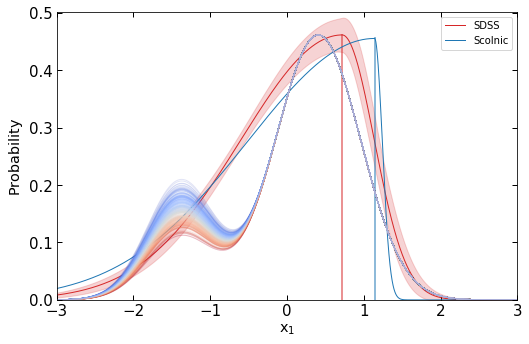

In [18]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

x_linspace = np.linspace(-3, 3, 3000)
flag_up = x_linspace >= assymSDSS.param['mu']

color_p = "C3"

pdf_SDSS = assymSDSS.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  assymSDSS.param['mu'],
                                  assymSDSS.param['sigma_m'],
                                  assymSDSS.param['sigma_p'])

ax.plot(x_linspace,
        pdf_SDSS,
        color=color_p,
        lw=1, label='SDSS')

ax.fill_between(x_linspace,
                pdf_SDSS + models_std_SDSS,
                pdf_SDSS - models_std_SDSS,
                color=color_p,
                lw=1, alpha=.2)

ax.vline(assymSDSS.param['mu'], ymin=0, ymax=np.max(pdf_SDSS),
         color=color_p, alpha=.5, linewidth=2.0)

mu_s = 1.141
sigma_m_s = 1.653
sigma_p_s = 0.1
flag_up_s = x_linspace >= mu_s

color_s = "C0"

pdf_SCO = assymSDSS.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  mu_s,
                                  sigma_m_s,
                                  sigma_p_s)

ax.plot(x_linspace,
        pdf_SCO,
        color=color_s, label='Scolnic',
        lw=1)

ax.vline(mu_s, 0, np.max(pdf_SCO),
         color=color_s, alpha=.5, linewidth=2.0)

dgmap = plt.cm.get_cmap('coolwarm')
nb_base = len(surv['SDSS'].zCMB)
i = 0

z_m, z_p = np.percentile(surv['SDSS'].zCMB, [0,100])

for z in surv['SDSS'].zCMB: #np.linspace(0.05, 1, nb_base)[:-1]:
    pdf = base.likelihood_tot(base.delta(z),
                              x_linspace, np.zeros(len(x_linspace)),
                              base.param['aa'],
                              base.param['mu_1'], base.param['sigma_1'],
                              base.param['mu_2'], base.param['sigma_2'])

    ax.plot(x_linspace,
            np.max(pdf_SDSS)/np.max(pdf)*pdf,
            color=dgmap((z-z_m)/(z_p-z_m)), alpha=.15,
            lw=1)
    i += 1
 
ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)
 
ax.set_xlim([-3, 3])
ax.set_ylim([0, np.max(pdf_SDSS+models_std_SDSS)+0.01])
                                                                      
ax.set_ylabel(r'$\mathrm{Probability}$', fontsize='x-large')
ax.set_xlabel(r'$\mathrm{x}_1$', fontsize='x-large')

ax.legend(ncol=1, loc='upper right')

fig.savefig('../../../Images/bbc_comp_SDSS.pdf', bbox_inches='tight')

In [40]:
assymPS1.get_logl()

702.0370318397174

In [41]:
base.get_logl()

268.57682453872195

# SNLS

## Définition de _cov_ pour sélection aléatoire des paramètres

In [20]:
cov_SNLS = im.Minuit.matrix(assymSNLS.m_tot)
mean_SNLS = [assymSNLS.m_tot.values[i] for i in range(3)]
param_hesse_mat_SNLS = scipy.stats.multivariate_normal.rvs(mean=mean_SNLS, cov=cov_SNLS, size=500)

### List of all the models

In [21]:
xlin = np.linspace(-3, 3, 3000)
models_hesse_SNLS = [assym_law_gen(xlin, param_hesse) for param_hesse in param_hesse_mat_SNLS]
models_hesse_SNLS = np.asarray(models_hesse_SNLS)

### Take _std_

In [22]:
models_std_SNLS = np.std(models_hesse_SNLS, axis=0)

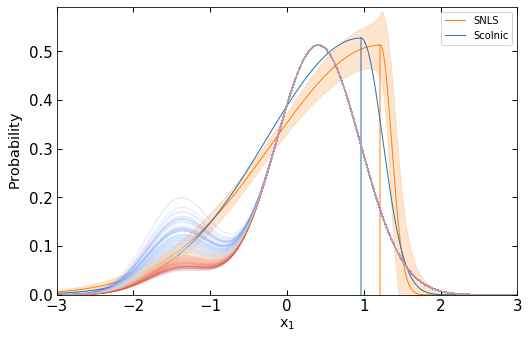

In [23]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

x_linspace = np.linspace(-3, 3, 3000)
flag_up = x_linspace >= assymSNLS.param['mu']

color_p = "C1"

pdf_SNLS = assymSNLS.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  assymSNLS.param['mu'],
                                  assymSNLS.param['sigma_m'],
                                  assymSNLS.param['sigma_p'])

ax.plot(x_linspace,
        pdf_SNLS,
        color=color_p,
        lw=1, label='SNLS')

ax.fill_between(x_linspace,
                pdf_SNLS + models_std_SNLS,
                pdf_SNLS - models_std_SNLS,
                color=color_p,
                lw=1, alpha=.2)

ax.vline(assymSNLS.param['mu'], ymin=0, ymax=np.max(pdf_SNLS),
         color=color_p, alpha=.5, linewidth=2.0)

mu_s = 0.964
sigma_m_s = 1.232
sigma_p_s = 0.282
flag_up_s = x_linspace >= mu_s

color_s = "C0"

pdf_SCO = assymSNLS.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  mu_s,
                                  sigma_m_s,
                                  sigma_p_s)

ax.plot(x_linspace,
        pdf_SCO,
        color=color_s, label='Scolnic',
        lw=1)

ax.vline(mu_s, 0, np.max(pdf_SCO),
         color=color_s, alpha=.5, linewidth=2.0)

dgmap = plt.cm.get_cmap('coolwarm')
nb_base = len(surv['SNLS'].zCMB)
i = 0

z_m, z_p = np.percentile(surv['SNLS'].zCMB, [0,100])

for z in surv['SNLS'].zCMB: #np.linspace(0.05, 1, nb_base)[:-1]:
    pdf = base.likelihood_tot(base.delta(z),
                              x_linspace, np.zeros(len(x_linspace)),
                              base.param['aa'],
                              base.param['mu_1'], base.param['sigma_1'],
                              base.param['mu_2'], base.param['sigma_2'])

    ax.plot(x_linspace,
            np.max(pdf_SNLS)/np.max(pdf)*pdf,
            color=dgmap((z-z_m)/(z_p-z_m)), alpha=.15,
            lw=1)
    i += 1
 
ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)
 
ax.set_xlim([-3, 3])
ax.set_ylim([0, np.max(pdf_SNLS+models_std_SNLS)+0.01])
                                                                      
ax.set_ylabel(r'$\mathrm{Probability}$', fontsize='x-large')
ax.set_xlabel(r'$\mathrm{x}_1$', fontsize='x-large')

ax.legend(ncol=1, loc='upper right')

fig.savefig('../../../Images/bbc_comp_SNLS.pdf', bbox_inches='tight')

## Get proba

In [11]:
def get_proba(model):
    return np.exp((evol3G2M1S.get_aicc() - model.get_aicc())/2)

In [48]:
modèles = [assymSDSS, assymPS1, assymSNLS]

assym_comp = pd.DataFrame({'Assym': ['SDSS', 'PS1', 'SNLS', 'Total'],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles] + [np.sum([len(k.FREEPARAMETERS) for k in modèles])],
                           '$\sigma^-$': [round(k.migrad_out[1][1][2],2) for k in modèles] + ['--'],
                           '$\sigma^-_{\mathrm{err}}$': [round(k.migrad_out[1][1][3],2) for k in modèles] + ['--'],
                           '$\sigma^+$': [round(k.migrad_out[1][2][2],2) for k in modèles] + ['--'],
                           '$\sigma^+_{\mathrm{err}}$': [round(k.migrad_out[1][2][3],2) for k in modèles] + ['--'],
                           '$\mu^0$': [round(k.migrad_out[1][0][2],2) for k in modèles] + ['--'],
                           '$\mu^0_{\mathrm{err}}$': [round(k.migrad_out[1][0][3],2) for k in modèles] + ['--'],
                           'ln $\mathcal{L}$': [round(k.get_logl(),1) for k in modèles] + [round(np.sum([k.get_logl() for k in modèles]),1)],
                           'AICc': [round(k.get_aicc(),1) for k in modèles] + [round(np.sum([k.get_aicc() for k in modèles]),1)]})

path = '../Data/assym_comp'
if cons.value:
    path += '_cons'
path += '.dat'
assym_comp.to_csv(path)

assym_comp

,Assym,Free param,$\sigma^-$,$\sigma^-_{\mathrm{err}}$,$\sigma^+$,$\sigma^+_{\mathrm{err}}$,$\mu^0$,$\mu^0_{\mathrm{err}}$,ln $\mathcal{L}$,AICc
0,SDSS,3,1.25,0.08,0.39,0.07,0.69,0.1,893.9,900.0
1,PS1,3,1,0.09,-0.49,0.09,0.42,0.12,702.0,708.1
2,SNLS,3,1.18,0.11,0.39,0.11,0.81,0.15,594.8,600.9
3,Total,9,--,--,--,--,--,--,2190.7,2209.0


## Minimisation du modèle SNF et calcul $\mathcal{L}$ pour surveys

In [17]:
gen.set_model('Evol3G2M2S')
gen.set_data(df[df['survey'] == 'SDSS'])
baseSDSS = gen.fit()

gen.set_data(df[df['survey'] == 'PS1'])
basePS1 = gen.fit()

gen.set_data(df[df['survey'] == 'SNLS'])
baseSNLS = gen.fit()

In [18]:
models = [basePS1, baseSDSS, baseSNLS]

snf_comp = pd.DataFrame({'Base': ['SDSS', 'PS1', 'SNLS', 'Total'],
                         'Free param': [0 for k in models] + [0],
                         'ln $\mathcal{L}$': [round(k.get_logl(),1) for k in models] + [round(np.sum([k.get_logl() for k in models]),1)],
                         'AICc': [round(k.get_aicc(),1) for k in models] + [round(np.sum([k.get_aicc() for k in models]),1)]})

path = '../Data/snf_comp'
if cons.value:
    path += '_cons'
path += '.dat'
snf_comp.to_csv(path)

snf_comp

,Base,Free param,ln $\mathcal{L}$,AICc
0,SDSS,0,395.2,405.6
1,PS1,0,444.7,455.0
2,SNLS,0,254.1,264.7
3,Total,0,1094.0,1125.4
